In [148]:
import os
import cv2
import torch
from torchvision import transforms
from prototypical_net import ConvNet
from PIL import Image
import random
from detect_object_multiscale import detect_object_multiscale
from matplotlib import pyplot as plt

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_sizes=[84, 96, 112, 128]
stride=20
extensions=(".jpg", ".jpeg", ".png")
# Load model
model = ConvNet().to(device)
# model.load_state_dict(torch.load("saved_models/protonet_class_independent.pth"))
model.load_state_dict(torch.load("saved_models/normal_model.pth"))
model.eval()


ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

### Transforms

In [150]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [151]:
workspace_path = "images/workspace-images/workspace15.png"
target_class = "apple"

support_dir = os.path.join("images/support-images-augmented", target_class)
support_paths = [
    os.path.join(support_dir, f)
    for f in os.listdir(support_dir)
    if f.lower().endswith(extensions)
]

# Select up to 10 random support images (or fewer if not enough)
selected_paths = random.sample(support_paths, k=min(10, len(support_paths)))

# Load, transform, and embed all support images
embeddings = []
for path in selected_paths:
    img = Image.open(path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model(tensor)
        embeddings.append(emb)

# Compute average embedding = class prototype
support_embedding = torch.mean(torch.stack(embeddings), dim=0)

# Load and process workspace image
workspace = cv2.imread(workspace_path)
workspace = cv2.cvtColor(workspace, cv2.COLOR_BGR2RGB)

In [152]:
result = detect_object_multiscale(
    model=model,
    support_path_list=support_paths,
    workspace_path=workspace_path,
    patch_sizes=patch_sizes,
    stride=stride,
    device=device,
    distance=4,
    threshold=0.0,
    confidence=0.6
)
result

[{'location': (468, 368),
  'distance': 0.1556686908006668,
  'patch_size': 96,
  'confidence': 0.8652998977649754},
 {'location': (368, 168),
  'distance': 0.1605132818222046,
  'patch_size': 96,
  'confidence': 0.8616876822209468},
 {'location': (628, 488),
  'distance': 0.16453838348388672,
  'patch_size': 96,
  'confidence': 0.8587093514327573},
 {'location': (308, 468),
  'distance': 0.18702776730060577,
  'patch_size': 96,
  'confidence': 0.8424402760805489},
 {'location': (168, 188),
  'distance': 0.2044028788805008,
  'patch_size': 96,
  'confidence': 0.8302869559142083},
 {'location': (688, 288),
  'distance': 0.2265707105398178,
  'patch_size': 96,
  'confidence': 0.8152811667579252},
 {'location': (682, 102),
  'distance': 0.23368333280086517,
  'patch_size': 84,
  'confidence': 0.8105807814795329},
 {'location': (88, 408),
  'distance': 0.3257957994937897,
  'patch_size': 96,
  'confidence': 0.7542639676349979}]

In [153]:
print(f"Number of detected objects: {len(result)}")

Number of detected objects: 8


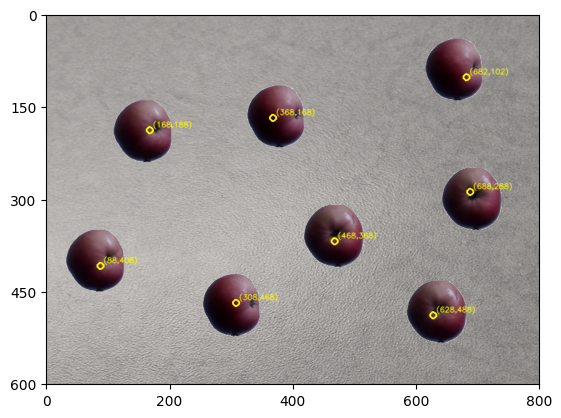

In [154]:
detected = "images/detected.png"
os.remove(detected) if os.path.exists(detected) else None
if result == []:
    print("Object not detected on the workspace.")
else:
    for loc in result:
        x, y = loc['location']
        cv2.circle(workspace, (x, y), 5, (255, 250, 0), 2)
        # Write coordinates near the circle
        text = f"({x},{y})"
        cv2.putText(workspace, text, (x + 5, y - 5), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=0.4, color=(255, 250, 0), thickness=1, lineType=cv2.LINE_AA)
    cv2.imwrite(detected, cv2.cvtColor(workspace, cv2.COLOR_RGB2BGR))
    
    plt.imshow(workspace)
    plt.xticks([0, 200, 400, 600, 800])
    plt.yticks([0, 150, 300, 450, 600])
    plt.show()